In [3]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%matplotlib inline

## SGD on weather radar image

In [5]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from regression import OLS

In Project 1 we used matrix inversion to solve the equations for OLS and Ridge. In this exercise I will solve the same equations using stocastic gradient descent. I have choosen to continue with the same weather radar image as I used in the first project:

SDG på værradar:
- Sammenlign med svaret fra skicit learn. Her skal det være ein SGD option som gjer at eg får samme matrise som over. ulike treff for 2 ulike parameter. 
- Gjer scalering riktig. Bruk cross validation og undersøk bootstrap dersom tid. 
- slides fra week 40 og seaborn er bra. 
- Gjer meg opp ein meining om cost-funksjon? ABS eller MSE? 
- sjå på korleis beta verdiane forbedrer seg for kvar iterasjon? Det kunne jo vært ult, men krev mange dimensjonar.
- Bruk autograd for derivering:) 

In [6]:
radar = np.load("nedbor_radar.npy") # from 2021-10-06 kl 11:45

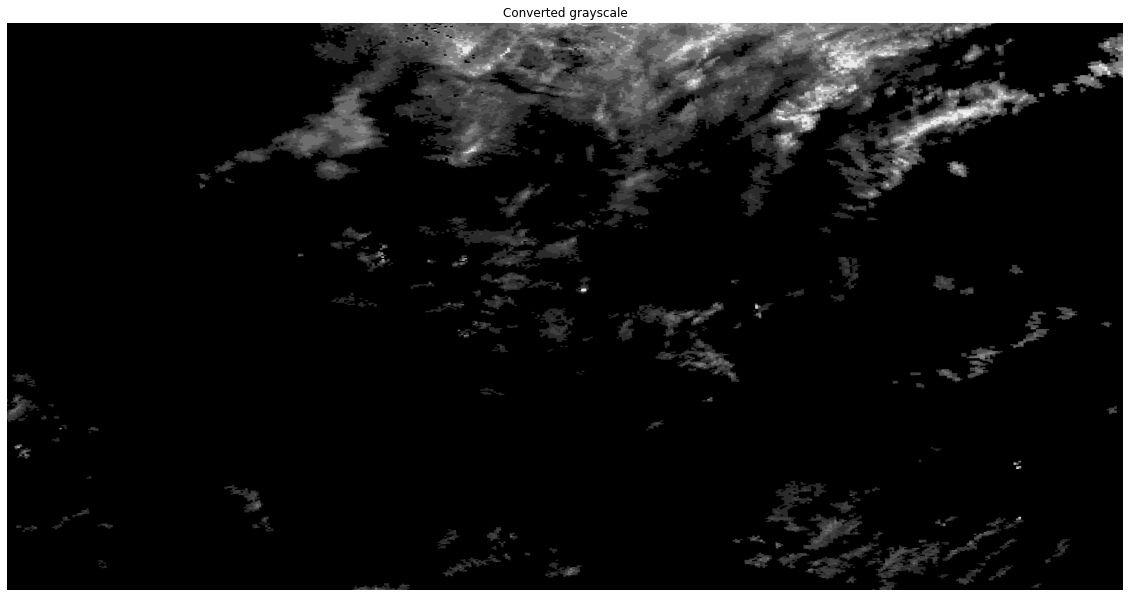

In [7]:
import matplotlib.image as mpimg
fig, ax = plt.subplots(1, 1, figsize=(20,15))
ax.imshow(radar, cmap='gray')
ax.set_title('Converted grayscale')

plt.axis('off')
plt.show()

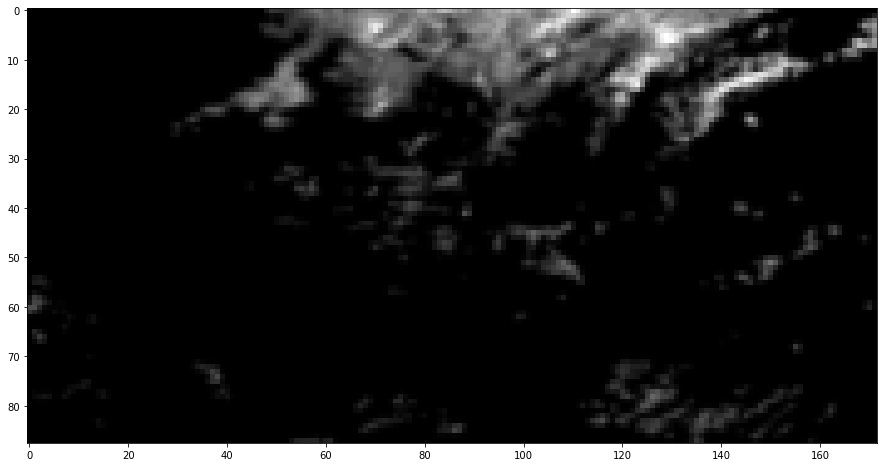

In [32]:
from skimage.transform import rescale
scale_factor = 0.05 # 0.015 and lower gives over-fitting tendencies
radar_rescaled = rescale(radar, scale_factor)

fig, ax = plt.subplots(figsize=(20,8))
ax.imshow(radar_rescaled, cmap='gray')
plt.show()

In [141]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm # progressbar

# my own library
from regression import OLS

#sk-learn linear regression for lasso analysis
#from sklearn.linear_model import Lasso as Lasso_skl
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import PolynomialFeatures

z = radar_rescaled
x = np.arange(z.shape[1])
y = np.arange(z.shape[0])
x, y = np.meshgrid(x, y)

poly = 2
k_folds = 5

MSE_test_OLS = [] 
MSE_train_OLS = []
betas_OLS = []

MSE_test_Ridge = [] 
MSE_train_Ridge = []
betas_Ridge = []
MSE_test_Ridge_l = [] 
MSE_train_Ridge_l = []
betas_Ridge_l = []

MSE_test_Lasso = [] 
MSE_train_Lasso = []
betas_Lasso = []
MSE_test_Lasso_l = [] 
MSE_train_Lasso_l = []
betas_Lasso_l = []

# Cross validation:
# shuffle data:
#x =  ((x.ravel() - np.mean(x.ravel()))/np.sqrt(np.var(x.ravel()))) 
#y =  ((y.ravel() - np.mean(y.ravel()))/np.sqrt(np.var(y.ravel()))) 
#z =  ((z.ravel() - np.mean(z.ravel()))/np.sqrt(np.var(z.ravel()))) 
xyz_shuffle = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])
np.random.shuffle(xyz_shuffle) # shuffle along axis 0
xyz_folds = np.array_split(xyz_shuffle, k_folds) # split into k-folds

for k in tqdm.tqdm(range(k_folds)):     
    # extract folds
    
    xyz_test = xyz_folds[k] # k-th fold is test 
    xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]) # skip k-th fold

    xy_train = xyz_train[:, 0:2]
    z_train = xyz_train[:, 2].reshape(-1, 1)
    xy_test = xyz_test[:, 0:2]
    z_test = xyz_test[:, 2].reshape(-1, 1)    
    
    #Scale groups using train mean and std
    xy_test[:, 0] =  (xy_test[:, 0] - np.mean(xy_train[:, 0])) /np.sqrt(np.var(xy_train[:, 0]))
    xy_test[:, 1] =  (xy_test[:, 1] - np.mean(xy_train[:, 1])) /np.sqrt(np.var(xy_train[:, 1]))
    z_test[:] =  (z_test[:] - np.mean(z_train[:])) /np.sqrt(np.var(z_train[:]))  
    xy_train[:, 0] =  (xy_train[:, 0] - np.mean(xy_train[:, 0]))  /np.sqrt(np.var(xy_train[:, 0]))
    xy_train[:, 1] =  (xy_train[:, 1] - np.mean(xy_train[:, 1]))  /np.sqrt(np.var(xy_train[:, 1]))
    z_train[:] =  (z_train[:] - np.mean(z_train[:]))  /np.sqrt(np.var(z_train[:]))

    # OLS:
    MSE_test = []
    MSE_train = []
    #                 1            2           3         4       5      6      7     8      9      10     11
    learning_rate = [100,  100,  0.00000001, 0.00000000001, 0.01, 0.01,   0.01,  0.01, 0.01,   0.01, 0.001]
    alpha =         [0.5,         0.5,      0.001,       0.001,   0.9,  0.9,    0.9,   0.9,   0.91,   0.8,    0.8]
    for poly_deg in range(1, poly + 1):
        model = OLS(poly_deg, learning_rate[poly_deg - 1], alpha[poly_deg - 1], batch_size=2, n_epochs=100)
        model.fit(xy_train, z_train) 
        #print(type(model.predict(xy_train)[0][0]))
        MSE_test.append(model.MSE(xy_test, z_test)) 
        MSE_train.append(model.MSE(xy_train, z_train))
    MSE_test_OLS.append(MSE_test) 
    MSE_train_OLS.append(MSE_train)

    # Ridge:
    #MSE_test = []
    #MSE_train = []
    #beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    #lambda_ridge = 50
    #for poly_deg in range(1, poly + 1):
    #    model = Ridge(xy_train[:, 0].ravel(), xy_train[:, 1].ravel(), z_train.ravel(), poly_deg, lambda_ridge) 
    #    MSE_test.append(model.MSE(xy_test[:, 0], xy_test[:, 1], z_test.ravel())) 
    #    MSE_train.append(model.MSE(xy_train[:, 0], xy_train[:, 1], z_train.ravel()))
    #    beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.beta_Ridge.ravel()) 
    #    beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan
    #    
    #MSE_test_Ridge.append(MSE_test) 
    #MSE_train_Ridge.append(MSE_train)
    #betas_Ridge.append(beta_poly) 
    
#convert to array
MSE_test_OLS = np.array(MSE_test_OLS)
MSE_train_OLS = np.array(MSE_train_OLS)

MSE_test_Ridge = np.array(MSE_test_Ridge)
MSE_train_Ridge = np.array(MSE_train_Ridge)

#study average values
expected_MSE_test_OLS = np.mean(MSE_test_OLS, axis=0) 
expected_MSE_train_OLS  = np.mean(MSE_train_OLS, axis=0)

100%|████| 5/5 [00:08<00:00,  1.71s/it]


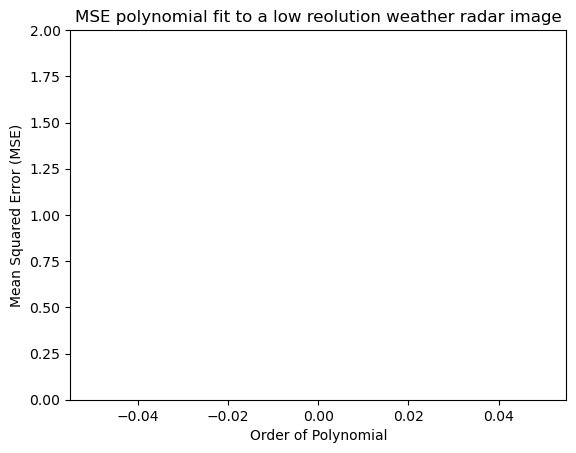

In [142]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.plot(range(1, len(MSE_test)+1), expected_MSE_test_OLS, 'g', label='OLS test')
plt.plot(range(1, len(MSE_train)+1), expected_MSE_train_OLS, 'r', label='OLS train')

plt.xlabel('Order of Polynomial')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE polynomial fit to a low reolution weather radar image')
plt.ylim(0, 2)
plt.show()

In [94]:
expected_MSE_test_OLS

array([0.00844156, 0.00788973,        nan,        nan])

## Visualize error in OLS 

In [171]:
import seaborn as sns
from regression import OLS
import tqdm
from franke_function import FrankeFunction as Fr

#sk-learn linear regression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

learning_rate = np.logspace(-5, -1, 6)
alpha = np.linspace(0, 0.99, len(learning_rate))
poly_deg = 4
k_folds = 5
batch_size = 256
n_epochs = 5

train_accuracy = np.zeros((len(learning_rate), len(alpha)))
test_accuracy = np.zeros((len(learning_rate), len(alpha)))
train_accuracy_skl = np.zeros((len(learning_rate), len(alpha)))
test_accuracy_skl = np.zeros((len(learning_rate), len(alpha)))

#Use radar data:
#z = radar_rescaled
#x = np.arange(z.shape[1])
#y = np.arange(z.shape[0])
#x, y = np.meshgrid(x, y)

x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)
noise = np.random.randn(x.shape[0], y.shape[1])
z = Fr(x, y) + noise*0.05


xyz_shuffle = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])
np.random.shuffle(xyz_shuffle) # shuffle along axis 0
xyz_folds = np.array_split(xyz_shuffle, k_folds)

for i in tqdm.tqdm(range(len(learning_rate))):
    for j in range(len(alpha)):
        R2_test = []
        R2_train = []
        R2_test_skl = []
        R2_train_skl = []
        for k in range(k_folds):     
            # extract folds
    
            xyz_test = xyz_folds[k].copy() # k-th fold is test 
            xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

            xy_train = xyz_train[:, 0:2]
            z_train = xyz_train[:, 2].reshape(-1, 1)
            xy_test = xyz_test[:, 0:2]
            z_test = xyz_test[:, 2].reshape(-1, 1)    
    
            #Scale groups using train mean and std
            xy_test[:, 0] =  xy_test[:, 0] - np.mean(xy_train[:, 0]) 
            xy_test[:, 1] =  xy_test[:, 1] - np.mean(xy_train[:, 1])
            z_test[:] =  z_test[:] - np.mean(z_train[:]) 
            xy_train[:, 0] =  xy_train[:, 0] - np.mean(xy_train[:, 0])  
            xy_train[:, 1] =  xy_train[:, 1] - np.mean(xy_train[:, 1])
            z_train[:] =  z_train[:] - np.mean(z_train[:])
            
            model = OLS(poly_deg, 0.1, learning_rate[i], alpha[j], batch_size, n_epochs)
            model.fit(xy_train, z_train) 
            R2_test.append(model.R2(xy_test, z_test)) 
            R2_train.append(model.R2(xy_train, z_train))
            
            model_skl = make_pipeline(PolynomialFeatures(degree=poly_deg), SGDRegressor(
                fit_intercept=False, learning_rate='constant', eta0=learning_rate[i]))
            model_skl.fit(xy_train, z_train.ravel()) #this one must be raveled, dont know why 
            skl_predict_test = model_skl.predict(xy_test)
            skl_predict_train = model_skl.predict(xy_train)
            R2_test_skl.append( r2_score(z_test.ravel(), skl_predict_test ) )
            R2_train_skl.append( r2_score(z_train.ravel(), skl_predict_train ) )
            
        train_accuracy[i][j] = np.mean(R2_train)
        test_accuracy[i][j] = np.mean(R2_test)
        train_accuracy_skl[i][j] = np.mean(R2_train_skl)
        test_accuracy_skl[i][j] = np.mean(R2_test_skl)
        


100%|███| 6/6 [01:03<00:00, 10.65s/it]


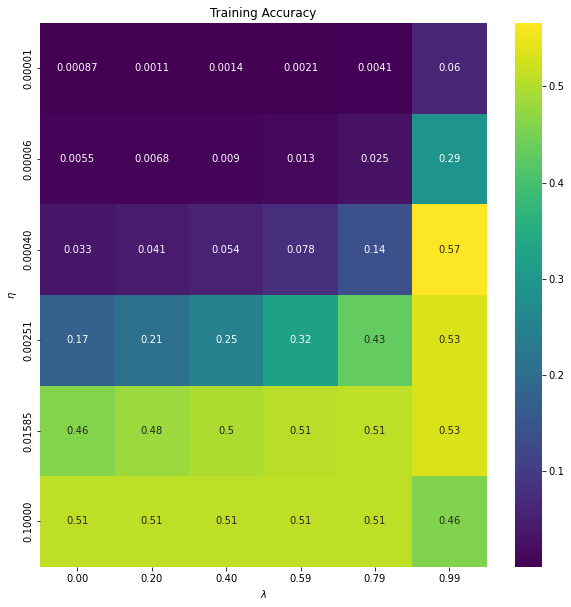

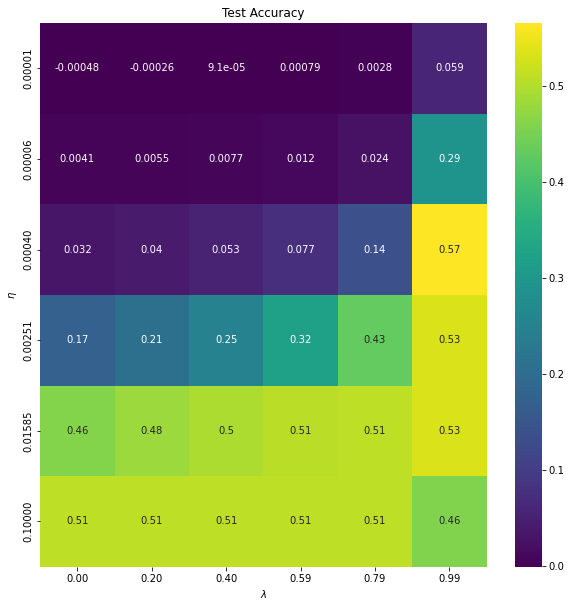

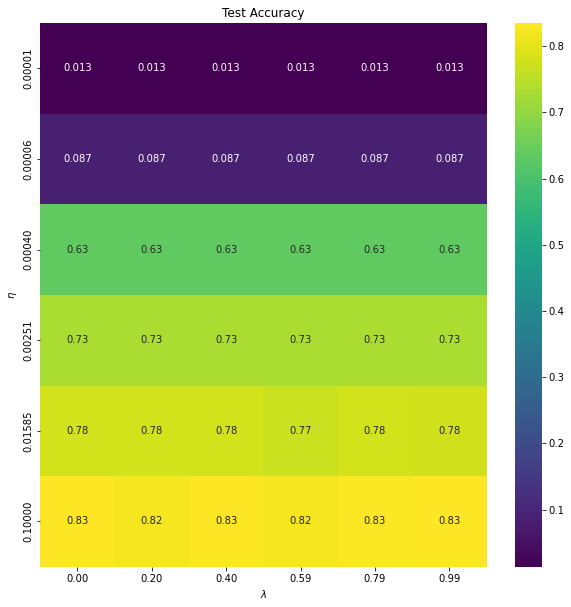

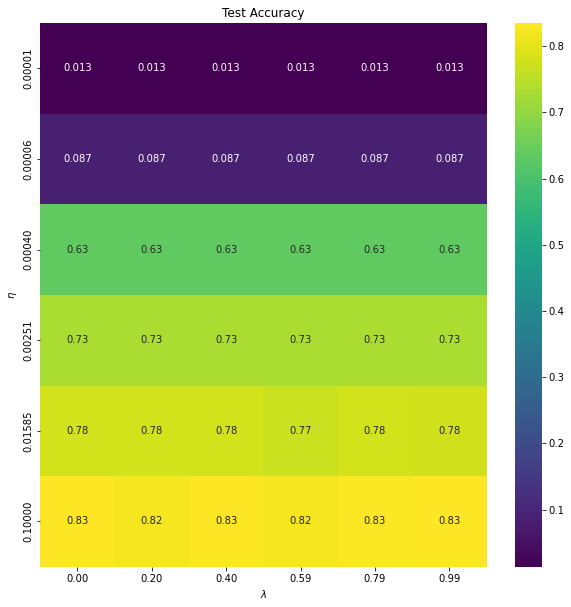

In [174]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in alpha] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )

plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in alpha] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy_skl, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in alpha] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy_skl, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in alpha] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

 - Ridge decreases accuracy, but saves model from exploding. 